In [1]:
import pandas as pd
import os

from mapboxgl.utils import *
from mapboxgl.viz import *
from mapboxgl.utils import create_color_stops, df_to_geojson
from mapboxgl.viz import CircleViz

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.vq import kmeans2, whiten

import pandas as pd
# Load Data Set
year  = "2020"
month = "08"
URL = f"https://data.urbansharing.com/oslobysykkel.no/trips/v1/{year}/{month}.csv"
o_df = pd.read_csv(URL)


#Matbox token
token = "pk.eyJ1IjoibWFwYm94IiwiYSI6ImNpejY4NXVycTA2emYycXBndHRqcmZ3N3gifQ.rJcFIG214AriISLbB6B5aw"
o_df.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2020-08-01 00:04:12.542000+00:00,2020-08-01 00:08:33.462000+00:00,260,423,Schous plass,nærmest rundkjøringen,59.920335,10.760804,460,Botanisk Hage sør,langs Jens Bjelkes gate,59.915418,10.769330
1,2020-08-01 01:54:23.528000+00:00,2020-08-01 02:01:20.350000+00:00,416,412,Jakob kirke,langs Torggata,59.917866,10.754898,503,Fagerheimgata,ved Dælenenga busstopp,59.927606,10.765985
2,2020-08-01 03:00:08.082000+00:00,2020-08-01 03:10:36.755000+00:00,628,407,Sagene bussholdeplass,langs Kierschovs gate,59.937743,10.751648,599,Paléhaven,langs Strandgata,59.910331,10.750110
3,2020-08-01 03:00:19.792000+00:00,2020-08-01 03:05:55.369000+00:00,335,579,Bogstadveien,ved Sporveisgata,59.924732,10.724628,623,7 Juni Plassen,langs Henrik Ibsens gate,59.915060,10.731272
4,2020-08-01 03:00:40.721000+00:00,2020-08-01 03:13:23.463000+00:00,762,525,Myraløkka Øst,ved Bentsenbrua,59.937205,10.760581,585,Nordre gate,ved Grünerbrua,59.921150,10.754714


In [2]:
#Converting dates to datetime
o_df["started_at"]= pd.to_datetime(o_df["started_at"]) 
o_df["ended_at"]= pd.to_datetime(o_df["ended_at"])
o_df['Ukedag'] = o_df['started_at'].dt.day_name()

In [3]:
# Not needed for current program
# df = o_df[["started_at","Ukedag","start_station_id","end_station_id"]]
# df = df.rename(columns={"start_station_id":"sId","end_station_id":"eId"})
# df.head()

In [4]:
o_df.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude,Ukedag
0,2020-08-01 00:04:12.542000+00:00,2020-08-01 00:08:33.462000+00:00,260,423,Schous plass,nærmest rundkjøringen,59.920335,10.760804,460,Botanisk Hage sør,langs Jens Bjelkes gate,59.915418,10.769330,Saturday
1,2020-08-01 01:54:23.528000+00:00,2020-08-01 02:01:20.350000+00:00,416,412,Jakob kirke,langs Torggata,59.917866,10.754898,503,Fagerheimgata,ved Dælenenga busstopp,59.927606,10.765985,Saturday
2,2020-08-01 03:00:08.082000+00:00,2020-08-01 03:10:36.755000+00:00,628,407,Sagene bussholdeplass,langs Kierschovs gate,59.937743,10.751648,599,Paléhaven,langs Strandgata,59.910331,10.750110,Saturday
3,2020-08-01 03:00:19.792000+00:00,2020-08-01 03:05:55.369000+00:00,335,579,Bogstadveien,ved Sporveisgata,59.924732,10.724628,623,7 Juni Plassen,langs Henrik Ibsens gate,59.915060,10.731272,Saturday
4,2020-08-01 03:00:40.721000+00:00,2020-08-01 03:13:23.463000+00:00,762,525,Myraløkka Øst,ved Bentsenbrua,59.937205,10.760581,585,Nordre gate,ved Grünerbrua,59.921150,10.754714,Saturday


In [5]:
#A class to keep station data
class station:
    def __init__(self, id,longitude,latitude,name, change = 0, zone = 0):
        self.id = id
        self.long = longitude
        self.lat = latitude
        self.name = name
        self.change = change
        self.zone = zone
    
    def updateChange(self, tick):
        self.change += tick
    def setZone(self, zone):
        self.zone = zone
    def getZone(self):
        return self.zone        
    def getId(self):
        return self.id
    def getName(self):
        return self.name
    def getLongLat(self):
        return [self.long,self.lat]
    def getChange(self):
        return self.change
    def export(self):
        return [self.id,self.name,self.long,self.lat,self.change,self.zone]

In [6]:
#Getting only uniqe station ID's
o_df = o_df.sort_values('start_station_id', ascending=False)
sdf = o_df.drop_duplicates(subset='start_station_name', keep='first')
sdf = sdf.sort_values('start_station_id', ascending=True)
sdf.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude,Ukedag
738,2020-08-01 08:51:13.898000+00:00,2020-08-01 09:01:26.176000+00:00,612,377,Tøyenparken,ved Caltexløkka,59.915667,10.777566,411,Hasle Torg,ved busstoppet,59.923240,10.792831,Saturday
280871,2020-08-30 15:29:33.358000+00:00,2020-08-30 15:45:21.389000+00:00,948,378,Colosseum Kino,langs Fridtjof Nansens vei,59.929843,10.711285,597,Fredensborg,ved rundkjøringen,59.920995,10.750358,Sunday
115071,2020-08-14 06:51:30.728000+00:00,2020-08-14 06:59:00.415000+00:00,449,380,Bentsebrugata,rett over busstoppet,59.939230,10.759170,391,St. Hanshaugen park vest,ved busstoppet Colletts gate,59.926871,10.738463,Friday
121727,2020-08-14 16:38:46.362000+00:00,2020-08-14 16:46:19.693000+00:00,453,381,Grønlands torg,ved Tøyenbekken,59.912520,10.762240,489,Torggata,ved Bernt Ankers gate,59.915983,10.751551,Friday
4679,2020-08-01 16:11:31.781000+00:00,2020-08-01 16:34:07.059000+00:00,1355,382,Stensgata,ved trikkestoppet,59.929586,10.732839,494,Rådhusbrygge 4,ved Nesoddbåten,59.910847,10.730377,Saturday


In [7]:
#Assign each station to it¨s own station object
listOfStations=[]
for index, row in sdf.iterrows():
                  #id,latitude,longitude
    tmp = station(row[3],row[6],row[7],row[4])
    listOfStations.append(tmp)


Text(0, 0.5, 'Longitude')

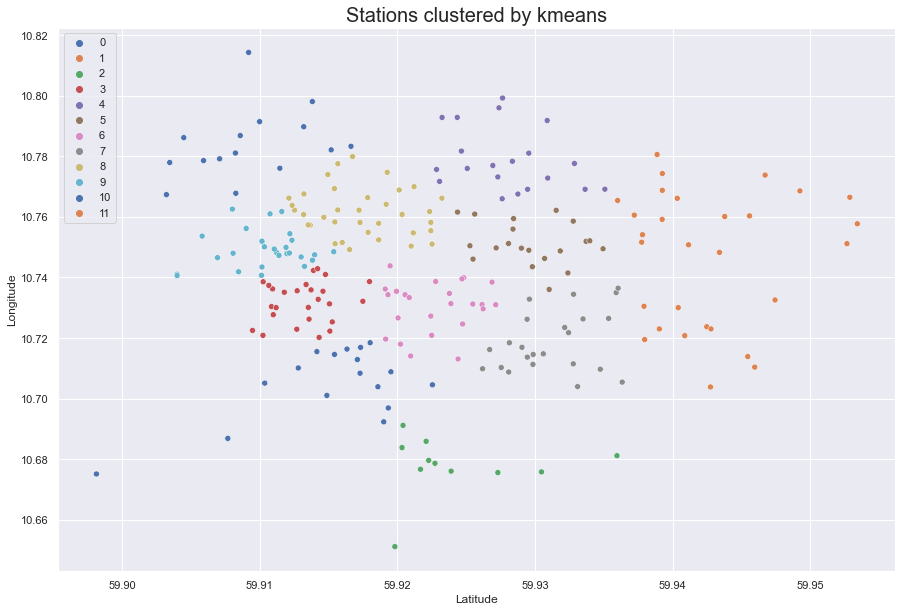

In [8]:
#Devide the stations to zones, based on kmeans2

cor = []
for station in listOfStations:
    cor.append(station.getLongLat())
coordinates= np.array(cor)
x, y = kmeans2(whiten(coordinates), 12, iter = 50)  
#y is the var with zones

#Plot the zones
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(data=coordinates, x=coordinates[:,0], y=coordinates[:,1], hue=y, palette="deep")
plt.title("Stations clustered by kmeans", fontsize=20)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Longitude', fontsize=12)

In [9]:
#Add zones to station object
for i in range(len(listOfStations)):
    listOfStations[i].setZone(y[i])

In [10]:
#Count trips from and to every station
#THIS ALG IS SLOW, CAN IT BE REWRITTEN???
for index, row in o_df.iterrows():
    sId = row[3]
    eId = row[8]
    for s in listOfStations:
        if s.getId() == sId:
            s.updateChange(-1)
            sId=False
        if s.getId() == eId:
            s.updateChange(1)
            eId=False
        if not sId and not eId:
            break

In [28]:
# Create a new df to easier convert it to geojson
newDf = pd.DataFrame(columns = ["Id", "Name", "Longitude", "Latitude", "Change", "Zone"])


In [29]:
newDf.head()

,Id,Name,Longitude,Latitude,Change,Zone


In [30]:
#Fill newDf with data
for s in listOfStations:
    series = pd.Series(s.export(), index = newDf.columns)

    newDf = newDf.append(series, ignore_index=True)

In [31]:
#Create a geojson object for mapbox plot
df_to_geojson(newDf, filename='points.geojson',
              properties=['Id', 'Name','Change','Zone'],
              lon='Latitude', lat='Longitude', precision=3)

{'type': 'file', 'filename': 'points.geojson', 'feature_count': 248}

In [32]:
#For html version
geoFile = "https://raw.githubusercontent.com/buzzCraft/MapBox-RadiusPlot/main/points.geojson"
#For local usage:
#geoFile ='points.geojson'

In [33]:
#Plot the change of bikes for each station
center =(10.77837,59.928349)
zoom = 10

# Generate data breaks and color stops from colorBrewer
color_breaks = [-2000,-1000,-100,-10, 0,10,100,1000,2000]
color_stops = create_color_stops(color_breaks, colors='Spectral')

# Create the viz from the dataframe
viz = CircleViz(geoFile,
                access_token=token,
                height='500px',
                radius=3,
                color_property = "Change",
                color_stops = color_stops,
                center = center,
                zoom = zoom,
                below_layer = 'waterway-label'
              )
viz.show()

D:\Programering\Programmer\Anaconda\envs\dave3625\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


![img/vizchange.png](img/vizchange.png)

In [34]:
#Plot clustered zones on the map
center =(10.77837,59.928349)
zoom = 10

# Generate data breaks and color stops from colorBrewer
color_breaks = [1,2,3,4,5,6,7,8,9,10,11,12]
color_stops = create_color_stops(color_breaks, colors='Set3')

# Create the viz from the dataframe
viz = CircleViz(geoFile,
                access_token=token,
                height='500px',
                radius=3,
                color_property = "Zone",
                color_stops = color_stops,
                center = center,
                zoom = zoom,
                below_layer = 'waterway-label'
              )
viz.show()

![img/zoneclust.png](img/zoneclust.png)

In [35]:
# Create a clustered circle map
color_stops = create_color_stops([1, 5, 10, 15], colors='YlOrBr')

viz4 = ClusteredCircleViz(geoFile, 
                          access_token=token,
                          color_stops=color_stops,
                          stroke_color='black',
                          radius_stops=[[1, 5], [10, 10], [50, 15], [100, 20]],
                          radius_default=2,
                          cluster_maxzoom=250,
                          cluster_radius=30,
                          label_size=12,
                          opacity=0.9,
                          center=center,
                          zoom=zoom)
viz4.show()

![img/visclust.png](img/visclust.png)

In [36]:
#Heatmap, dont make too much sense
heatmap_color_stops = create_color_stops([0.01, 0.25, 0.5, 0.75, 1], colors='RdPu')
heatmap_radius_stops = [[0, 2], [1, 40]] # increase radius with zoom

color_breaks = [round(newDf["Change"].quantile(q=x*0.1), 2) for x in range(2, 10)]
color_stops = create_color_stops(color_breaks, colors='Spectral')

heatmap_weight_stops = create_weight_stops(color_breaks)

# Create the heatmap 
viz3 = HeatmapViz(geoFile, 
                  access_token=token,
                  weight_property="Change",
                  weight_stops=heatmap_weight_stops,
                  color_stops=heatmap_color_stops,
                  radius_stops=heatmap_radius_stops,
                  opacity=0.8,
                  center=center,
                  height='600px',
                  zoom=zoom,
                  below_layer='waterway-label')
viz3.show()

![img/vizheat.png](img/vizheat.png)

In [37]:
# #another change plot
# # Generate data breaks and color stops from colorBrewer
# measure_color = 'Change'
# color_breaks = [round(newDf[measure_color].quantile(q=x*0.1), 2) for x in range(2, 10)]
# color_stops = create_color_stops(color_breaks, colors='Set3')

# # Generate radius breaks from data domain and circle-radius range
# measure_radius = 'Change' #For testing
# radius_breaks = [round(newDf[measure_radius].quantile(q=x*0.1), 2) for x in range(2, 10)]
# radius_stops = create_radius_stops(radius_breaks, 0.5, 20)

# # Create the viz
# viz2 = GraduatedCircleViz(geoFile, 
#                           access_token=token,
#                           color_property="Change",
#                           color_stops=color_stops,
#                           radius_property="Change",
#                           radius_stops=radius_stops,
#                           stroke_color='black',
#                           stroke_width=0.5,
#                           center=center,
#                           zoom=zoom,
#                           opacity=0.75,
#                           below_layer='waterway-label')
# viz2.show()

![img/viz2.png](img/viz2.png)

In [38]:
from geojson_utils import centroid
newDf.head()

,Id,Name,Longitude,Latitude,Change,Zone
0,377,Tøyenparken,59.915667,10.777566,-88,8
1,378,Colosseum Kino,59.929843,10.711285,-7,7
2,380,Bentsebrugata,59.939230,10.759170,-120,11
3,381,Grønlands torg,59.912520,10.762240,128,8
4,382,Stensgata,59.929586,10.732839,-8,7


In [39]:
#Example dataset used for training and predicting
sampleDf = pd.DataFrame(columns = ["station_id", "capacity", "bikes_at_station", "timestamp", "status", "Delivered", "data1", "data..n"])
series = pd.Series([1,10,5,"2020-08-01 08:51:09.122000+00:00",0.5,0,"sample","sample"],index = sampleDf.columns)
sampleDf = sampleDf.append(series, ignore_index=True)
series = pd.Series([1,10,6,"2020-08-01 08:54:13.898000+00:00",0.6,1,"sample","sample"],index = sampleDf.columns)
sampleDf = sampleDf.append(series, ignore_index=True)
series = pd.Series([3,16,4,"2020-08-01 08:54:14.878000+00:00",0.25,0,"sample","sample"],index = sampleDf.columns)
sampleDf = sampleDf.append(series, ignore_index=True)

In [40]:
sampleDf.head()

,station_id,capacity,bikes_at_station,timestamp,status,Delivered,data1,data..n
0,1,10,5,2020-08-01 08:51:09.122000+00:00,0.50,0,sample,sample
1,1,10,6,2020-08-01 08:54:13.898000+00:00,0.60,1,sample,sample
2,3,16,4,2020-08-01 08:54:14.878000+00:00,0.25,0,sample,sample
